In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

M_PI = 3.14159265358979

propThrustFactor_x = -0.002403361
propThrustFactor_y = -0.1119465
propThrustFactor_z = 7.53844
maxRPM = 24000
propA = 0.0000000157
propTorqFactor = 0.01
propInertia = 2.113e-06
#propInertia = 8.13e-06

motorKV = 2800
motorR = 0.26
motorI0 = 0.81

vbat = 12.0


factor = 60

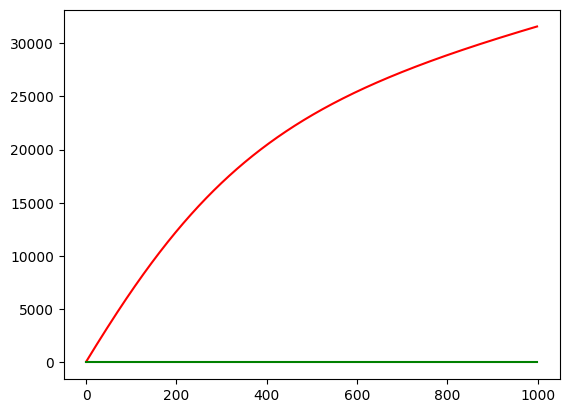

In [5]:

def prop_thrust(rpm, vel):
  # max thrust vs velocity:
  propF = propThrustFactor_x * vel * vel + propThrustFactor_y * vel + propThrustFactor_z
  propF = max(0.0, propF)

  # thrust vs rpm (and max thrust)
  b = (propF - propA * maxRPM * maxRPM) / maxRPM
  result = b * rpm + propA * rpm * rpm

  return  max(result, 0.0)



def prop_torque(rpm, vel):
  return prop_thrust(rpm, vel) * propTorqFactor



def motor_torque(volts, rpm):
  current = (volts - (rpm / motorKV)) / motorR

  if (current > 0):
    current = max(0.0, current - motorI0)
  elif (current < 0):
    current = min(0.0, current + motorI0)
  return current * factor / (motorKV * 2.0 * M_PI)



def clamp(n, smallest, largest): return max(smallest, min(n, largest))



rpmList = []
ptorqueList = []

current_rpm = 0

for t in range(0, 1000):

  #pwm = 1000.0 + (t / 10.0)
  pwm  = t * 1 + 1000

  if (pwm > 2000):
    pwm = 2000



  rpm = current_rpm

  volts = pwm / 1000.0 * vbat
  
  mtorque = motor_torque(volts, rpm)

  ptorque = prop_torque(rpm, 0)
  nettorque = mtorque - ptorque
  domega = nettorque / propInertia

  freq = 10e3
  DELTA = 1e6 / freq
  dt = DELTA / 1e6

  drpm = (domega * dt) * factor / (2.0 * M_PI)

  maxdrpm = abs(volts * motorKV - rpm)
  rpm += clamp(drpm, -maxdrpm, maxdrpm)

  current_rpm = rpm

  rpmList.append(rpm)  
  ptorqueList.append(ptorque)


rpmPoints = np.array(rpmList)
ptorquePoints = np.array(ptorqueList)


plt.plot(rpmPoints, color = "r")
plt.plot(ptorquePoints, color = "g")

plt.show() 